
# HIT140 — Assessment 3: **Investigation B**
**Dataset:** `dataset2.csv`  
**Focus:** Seasonal and temporal patterns in rat activity (30‑minute windows)

**Objectives**
1) Descriptive analysis; 2) Inferential tests (ANOVA, correlations);
3) Linear Regression (overall); 4) Winter vs Spring separate LR models.


In [2]:

import warnings; warnings.filterwarnings("ignore")
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120

FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
print("Libraries ready. Figures will be saved to:", FIG_DIR.resolve())


Libraries ready. Figures will be saved to: D:\AssignmentAU\yeshwanth\Assignment4\figs


## 1) Load Data

In [3]:

df = pd.read_csv("dataset2.csv")
df.columns = [c.strip() for c in df.columns]
print("dataset2.csv shape:", df.shape)
display(df.head(5))


dataset2.csv shape: (2123, 7)


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


## 2) Cleaning & Feature Engineering

In [5]:

def to_dt(s): return pd.to_datetime(s, errors="coerce", dayfirst=True)
if "time" in df.columns: df["time"] = to_dt(df["time"])

for c in ["month","hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

print("Distinct month values in dataset:")
print(sorted(df["month"].dropna().unique()))

if "season" not in df.columns and "month" in df.columns:
    def month_to_season(m):
        if pd.isna(m):
            return np.nan
        m = int(m)
        if m in (0, 1, 2):
            return "Summer"
        elif m in (3, 4, 5):
            return "Autumn"
        elif m in (6, 7, 8):
            return "Winter"
        else:
            return "Spring"

    df["season"] = df["month"].apply(month_to_season)

# Verify mapping
print(df[["month", "season"]].drop_duplicates().sort_values("month"))

df = df.dropna(subset=["rat_arrival_number","rat_minutes","hours_after_sunset"])

print("After cleaning:", df.shape)
display(df.head(5))
print("Missing values per column:")
print(df.isna().sum())


Distinct month values in dataset:
[0, 1, 2, 3, 4, 5, 6]
      month  season
0         0  Summer
156       1  Summer
439       2  Summer
880       3  Autumn
1012      4  Autumn
1593      5  Autumn
2111      6  Winter
After cleaning: (2123, 8)


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,season
0,2017-12-26 16:13:00,0,-0.5,20,4.000000,0.0,0,Summer
1,2017-12-26 16:43:00,0,0.0,28,4.000000,0.0,0,Summer
2,2017-12-26 17:13:00,0,0.5,25,4.000000,0.0,0,Summer
3,2017-12-26 17:43:00,0,1.0,71,4.000000,0.0,0,Summer
4,2017-12-26 18:13:00,0,1.5,44,3.753857,0.0,0,Summer


Missing values per column:
time                  0
month                 0
hours_after_sunset    0
bat_landing_number    0
food_availability     0
rat_minutes           0
rat_arrival_number    0
season                0
dtype: int64


## 3) Descriptive Analysis

,count,mean,std,min,25%,50%,75%,max
hours_after_sunset,2123.0,5.27,4.08,-2.0,2.00,5.00,8.50,13.5
bat_landing_number,2123.0,32.08,25.61,0.0,11.00,27.00,48.00,178.0
food_availability,2123.0,2.45,1.22,0.0,1.96,2.95,3.11,4.0
rat_minutes,2123.0,1.99,6.79,0.0,0.00,0.00,0.16,120.0
rat_arrival_number,2123.0,0.44,1.02,0.0,0.00,0.00,1.00,17.0


season                     Autumn  Summer  Winter
hours_after_sunset count  1231.00  880.00   12.00
                   mean      5.03    5.57    7.25
                   std       4.15    3.97    1.80
                   min      -2.00   -2.00    4.50
                   25%       1.50    2.38    5.88
                   50%       5.00    5.50    7.25
                   75%       8.50    9.00    8.62
                   max      13.50   13.50   10.00
bat_landing_number count  1231.00  880.00   12.00
                   mean     28.66   36.76   40.67
                   std      25.55   24.90   29.56
                   min       0.00    1.00    2.00
                   25%      10.00   15.00    7.00
                   50%      22.00   35.00   55.00
                   75%      40.50   53.00   61.25
                   max     178.00  130.00   79.00
food_availability  count  1231.00  880.00   12.00
                   mean      2.53    2.34    1.45
                   std       1.11    1.35    0.57
                   min       0.00    0.00    1.00
                   25%       2.00    1.02    1.00
                   50%       3.00    2.46    1.06
                   75%       3.00    3.80    1.97
                   max       4.00    4.00    2.58
rat_minutes        count  1231.00  880.00   12.00
                   mean      3.10    0.47    0.00
                   std       8.64    1.67    0.00
                   min       0.00    0.00    0.00
                   25%       0.00    0.00    0.00
                   50%       0.00    0.00    0.00
                   75%       2.67    0.00    0.00
                   max     120.00   16.02    0.00
rat_arrival_number count  1231.00  880.00   12.00
                   mean      0.60    0.24    0.00
                   std       1.06    0.92    0.00
                   min       0.00    0.00    0.00
                   25%       0.00    0.00    0.00
                   50%       0.00    0.00    0.00
                   75%       1.00    0.00    0.00
                   max       7.00   17.00    0.00


Season counts:


,count,prop
season,,
Autumn,1231,0.580
Summer,880,0.415
Winter,12,0.006



Month counts:


,count,prop
month,,
0,156,0.073
1,283,0.133
2,441,0.208
3,132,0.062
4,581,0.274
5,518,0.244
6,12,0.006


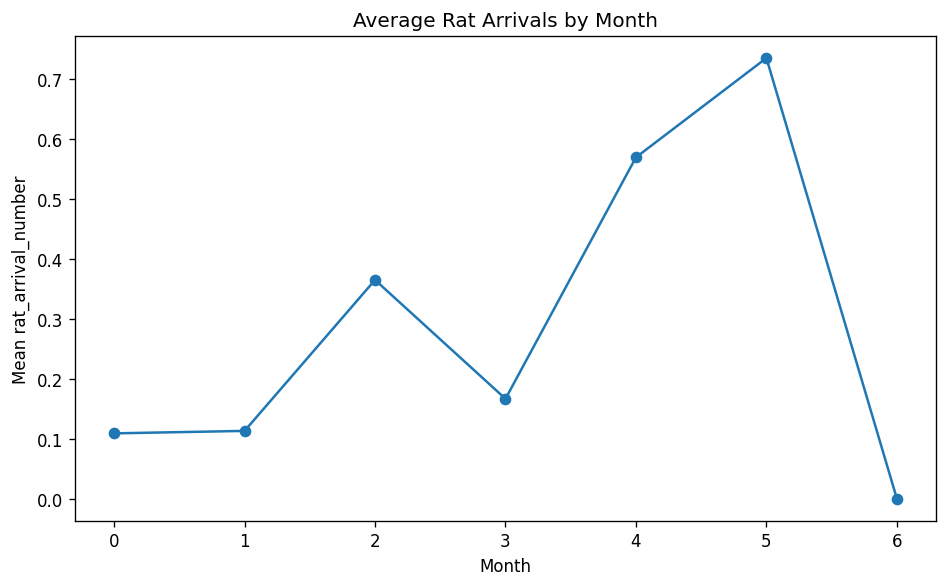

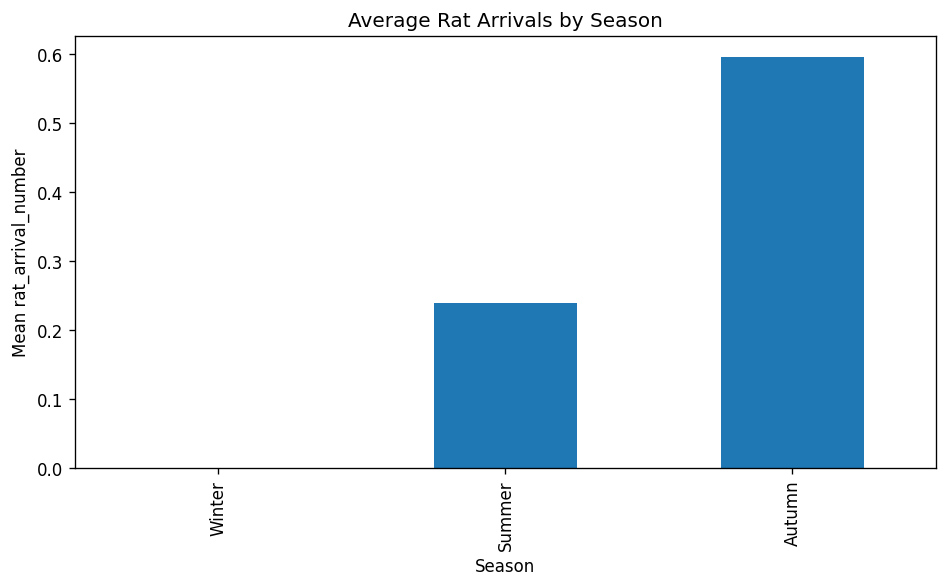

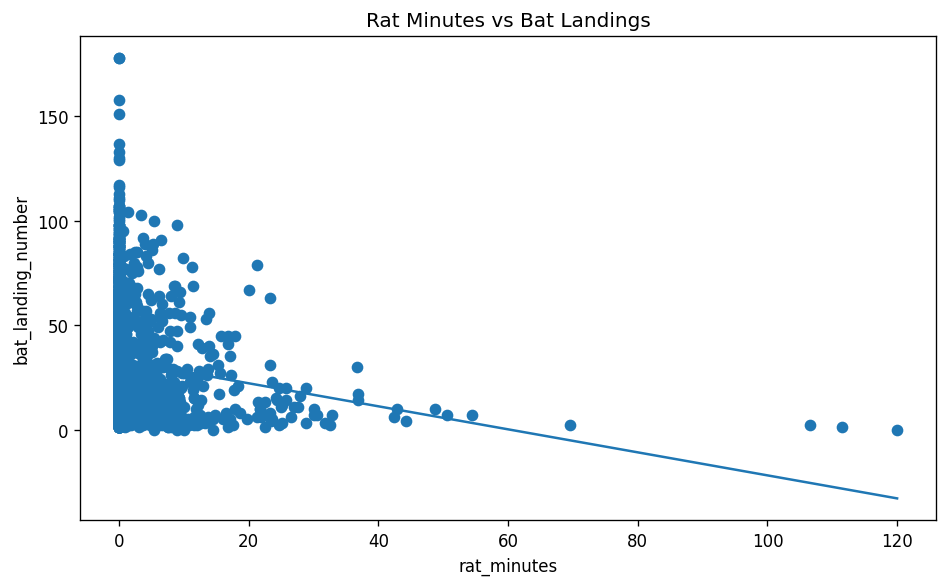

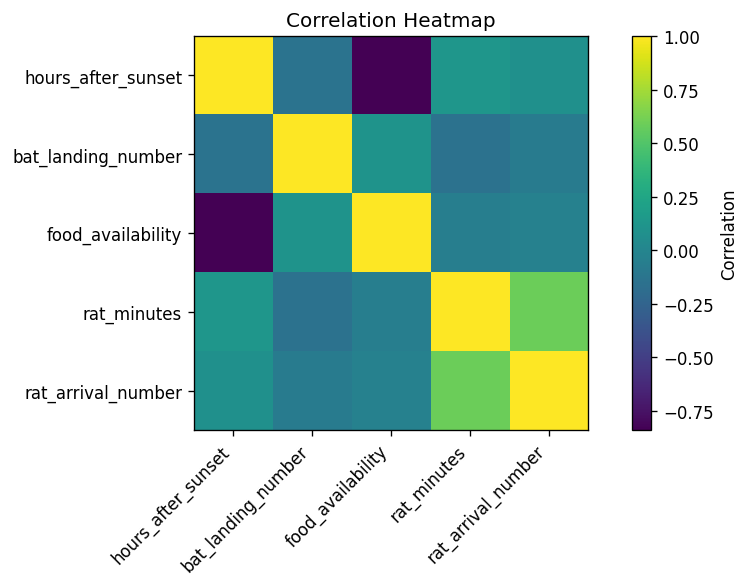

In [6]:

def summarize_numeric(df, cols, group=None):
    cols = [c for c in cols if c in df.columns]
    if group is None:
        return df[cols].describe().T
    return df.groupby(group)[cols].describe().T

num_cols = ["hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number"]
display(summarize_numeric(df, num_cols).round(2))
display(summarize_numeric(df, num_cols, "season").round(2))

def prop_table(s):
    c = s.value_counts(dropna=False).sort_index()
    p = s.value_counts(normalize=True, dropna=False).sort_index().round(3)
    return pd.DataFrame({"count": c, "prop": p})

print("\nSeason counts:")
display(prop_table(df["season"]))

if "month" in df.columns:
    print("\nMonth counts:")
    display(prop_table(df["month"]))

# Figures
if "month" in df.columns:
    plt.figure()
    df.groupby("month")["rat_arrival_number"].mean().plot(kind="line", marker="o")
    plt.title("Average Rat Arrivals by Month")
    plt.xlabel("Month"); plt.ylabel("Mean rat_arrival_number"); plt.tight_layout()
    plt.savefig(FIG_DIR / "b_rat_arrivals_by_month.png"); plt.show()

plt.figure()
df.groupby("season")["rat_arrival_number"].mean().sort_values().plot(kind="bar")
plt.title("Average Rat Arrivals by Season")
plt.xlabel("Season"); plt.ylabel("Mean rat_arrival_number"); plt.tight_layout()
plt.savefig(FIG_DIR / "b_rat_arrivals_by_season.png"); plt.show()

if "bat_landing_number" in df.columns:
    plt.figure()
    plt.scatter(df["rat_minutes"], df["bat_landing_number"])
    x = df["rat_minutes"].to_numpy(); y = df["bat_landing_number"].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 2:
        m, b = np.polyfit(x[mask], y[mask], 1)
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 100); ys = m*xs + b
        plt.plot(xs, ys)
    plt.title("Rat Minutes vs Bat Landings")
    plt.xlabel("rat_minutes"); plt.ylabel("bat_landing_number"); plt.tight_layout()
    plt.savefig(FIG_DIR / "b_rat_vs_bat_scatter.png"); plt.show()

plt.figure()
corr = df[num_cols].corr()
plt.imshow(corr, interpolation="nearest")
plt.colorbar(label="Correlation")
plt.title("Correlation Heatmap"); plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index); plt.tight_layout()
plt.savefig(FIG_DIR / "b_correlation_heatmap.png"); plt.show()


## 4) Inferential Analysis

In [7]:

# ANOVA by season
if "season" in df.columns and df["season"].nunique() > 1:
    groups = [g.dropna().values for _, g in df.groupby("season")["rat_arrival_number"]]
    if len(groups) >= 2 and all(len(g) > 2 for g in groups):
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"ANOVA (rat_arrival_number ~ season): F={f_stat:.3f}, p={p_val:.4f}")
    else:
        print("Not enough data per season for ANOVA.")
else:
    print("Season missing or constant; ANOVA skipped.")

# Correlations with rat_arrival_number
def corr_report(x, y, name_x, name_y):
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 2:
        r_p, p_p = stats.pearsonr(x[mask], y[mask])
        r_s, p_s = stats.spearmanr(x[mask], y[mask])
        print(f"Pearson({name_x},{name_y}): r={r_p:.3f}, p={p_p:.4f} | Spearman r={r_s:.3f}, p={p_s:.4f}")

print("\nCorrelation tests vs rat_arrival_number:")
for var in ["hours_after_sunset","food_availability","bat_landing_number","rat_minutes"]:
    if var in df.columns:
        corr_report(df[var].to_numpy(), df["rat_arrival_number"].to_numpy(), var, "rat_arrival_number")


ANOVA (rat_arrival_number ~ season): F=33.750, p=0.0000

Correlation tests vs rat_arrival_number:
Pearson(hours_after_sunset,rat_arrival_number): r=0.086, p=0.0001 | Spearman r=0.121, p=0.0000
Pearson(food_availability,rat_arrival_number): r=-0.034, p=0.1213 | Spearman r=-0.093, p=0.0000
Pearson(bat_landing_number,rat_arrival_number): r=-0.074, p=0.0007 | Spearman r=-0.095, p=0.0000
Pearson(rat_minutes,rat_arrival_number): r=0.585, p=0.0000 | Spearman r=0.983, p=0.0000


## 5) Linear Regression — Overall Model

Overall LR — R²=0.375, MAE=0.442, RMSE=0.784


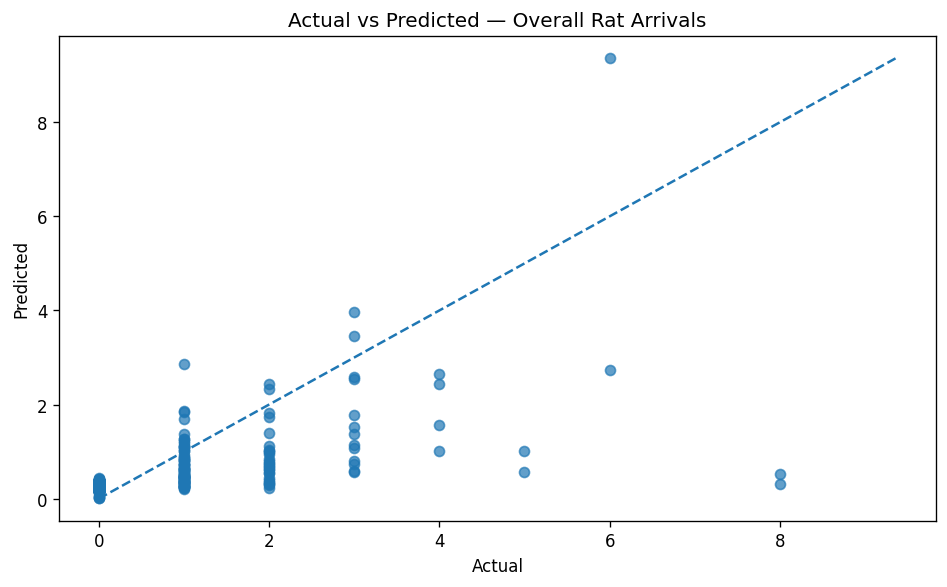

,Feature,Coefficient
1,season_Winter,-0.333336
0,season_Summer,-0.140379
4,bat_landing_number,0.000346
2,hours_after_sunset,0.012368
3,food_availability,0.029550
5,rat_minutes,0.084463


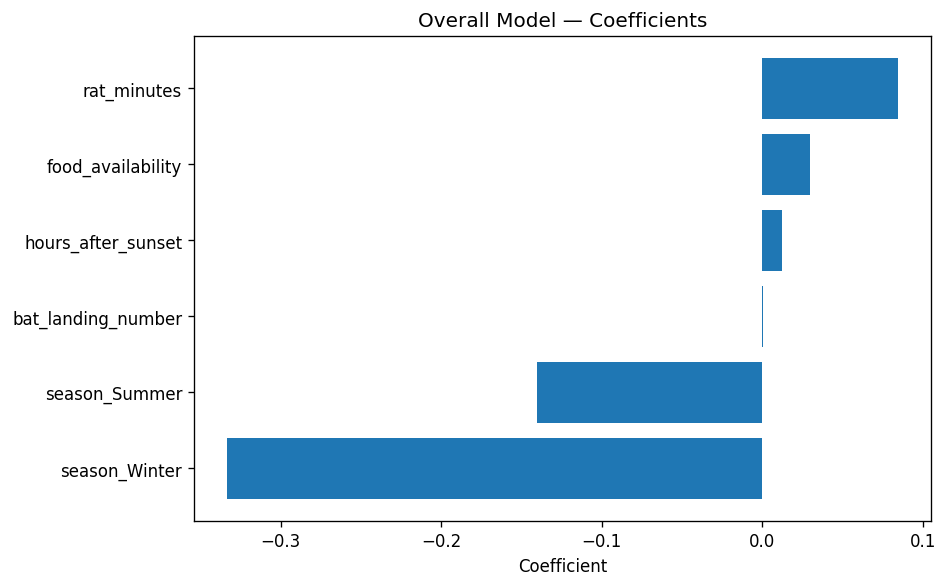

In [8]:

y = df["rat_arrival_number"].astype(float)
X_cols = ["hours_after_sunset","food_availability","bat_landing_number","rat_minutes","season"]
X = df[X_cols].copy()

categorical = ["season"]
numeric = ["hours_after_sunset","food_availability","bat_landing_number","rat_minutes"]

preprocess = ColumnTransformer([("cat", OneHotEncoder(drop="first"), categorical),
                                ("num", "passthrough", numeric)])

pipe = Pipeline([("prep", preprocess), ("lr", LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
print(f"Overall LR — R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")

# Actual vs Predicted
plt.figure()
plt.scatter(y_test, pred, alpha=0.7)
mn, mx = float(np.min([y_test.min(), pred.min()])), float(np.max([y_test.max(), pred.max()]))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.title("Actual vs Predicted — Overall Rat Arrivals")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout()
plt.savefig(FIG_DIR / "b_overall_actual_vs_pred.png"); plt.show()

# Coefficients
cat_names = pipe.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(["season"])
feat_names = list(cat_names) + numeric
coef_df_overall = pd.DataFrame({"Feature": feat_names, "Coefficient": pipe.named_steps["lr"].coef_}).sort_values("Coefficient")
display(coef_df_overall)

plt.figure()
plt.barh(coef_df_overall["Feature"], coef_df_overall["Coefficient"])
plt.title("Overall Model — Coefficients"); plt.xlabel("Coefficient")
plt.tight_layout(); plt.savefig(FIG_DIR / "b_overall_coefficients.png"); plt.show()


## 6) Seasonal Models — Winter vs Spring

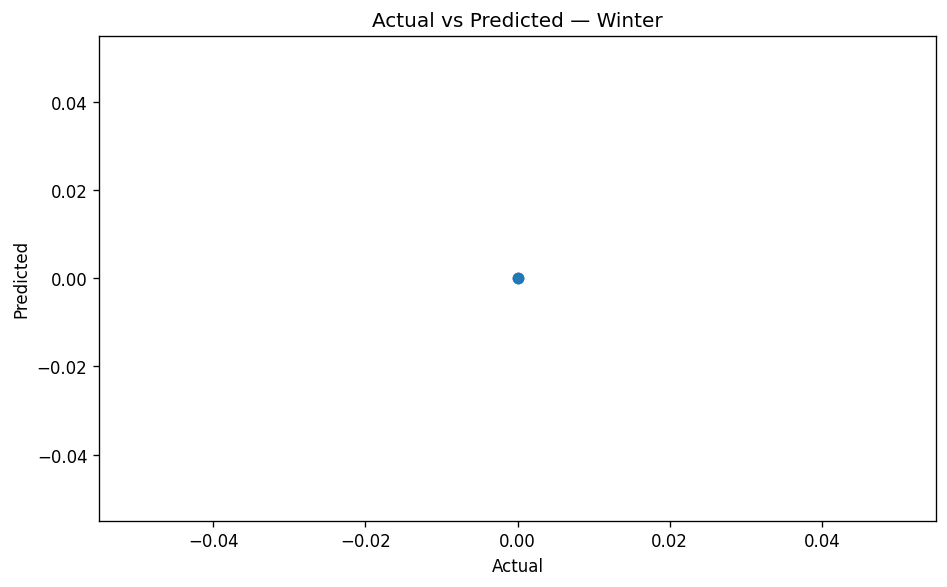

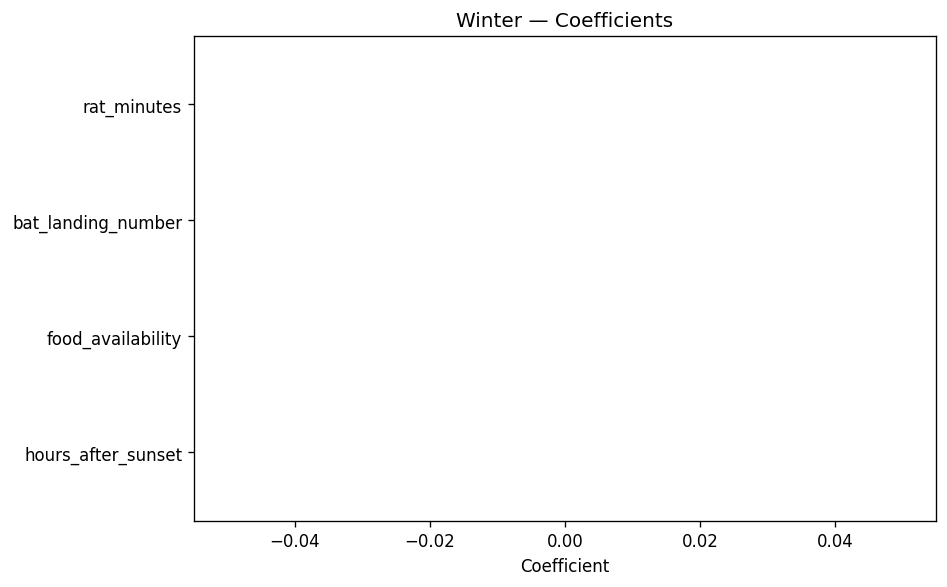

,Season,R2,MAE,RMSE
0,Winter,1.0,0.0,0.0
1,Spring,NaN,NaN,NaN


,Feature,Coefficient_Winter,Coefficient_Spring
0,bat_landing_number,0.0,NaN
1,food_availability,0.0,NaN
2,hours_after_sunset,0.0,NaN
3,rat_minutes,0.0,NaN


In [9]:

def fit_lr_subset(df_sub, label):
    y = df_sub["rat_arrival_number"].astype(float)
    X = df_sub[["hours_after_sunset","food_availability","bat_landing_number","rat_minutes"]].copy()
    if len(df_sub) < 8:
        return {"Season": label, "R2": np.nan, "MAE": np.nan, "RMSE": np.nan, "coef_df": pd.DataFrame(columns=["Feature","Coefficient"])}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lr.coef_}).sort_values("Coefficient")

    # Plots
    plt.figure()
    plt.scatter(y_test, pred, alpha=0.7)
    mn, mx = float(np.min([y_test.min(), pred.min()])), float(np.max([y_test.max(), pred.max()]))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.title(f"Actual vs Predicted — {label}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout()
    plt.savefig(FIG_DIR / f"b_{label.lower()}_actual_vs_pred.png"); plt.show()

    plt.figure()
    plt.barh(coef_df["Feature"], coef_df["Coefficient"])
    plt.title(f"{label} — Coefficients"); plt.xlabel("Coefficient")
    plt.tight_layout(); plt.savefig(FIG_DIR / f"b_{label.lower()}_coefficients.png"); plt.show()

    return {"Season": label, "R2": r2, "MAE": mae, "RMSE": rmse, "coef_df": coef_df}

winter = df[df["season"]=="Winter"].dropna(subset=["rat_arrival_number","hours_after_sunset","food_availability","bat_landing_number","rat_minutes"])
spring = df[df["season"]=="Spring"].dropna(subset=["rat_arrival_number","hours_after_sunset","food_availability","bat_landing_number","rat_minutes"])

res_winter = fit_lr_subset(winter, "Winter")
res_spring = fit_lr_subset(spring, "Spring")

metrics = pd.DataFrame([
    {"Season": res_winter["Season"], "R2": res_winter["R2"], "MAE": res_winter["MAE"], "RMSE": res_winter["RMSE"]},
    {"Season": res_spring["Season"], "R2": res_spring["R2"], "MAE": res_spring["MAE"], "RMSE": res_spring["RMSE"]},
])
display(metrics)

coef_compare = res_winter["coef_df"].merge(res_spring["coef_df"], on="Feature", how="outer", suffixes=("_Winter","_Spring"))
display(coef_compare)


## 7) Results and Interpretation

### Overall Linear Regression Model

The overall regression model achieved **R² = 0.375**, **MAE = 0.442**, and **RMSE = 0.784**, indicating that the predictors together explained approximately **37.5% of the variance** in rat arrivals across the 30-minute observation periods. This reflects a **moderate level of explanatory power**, acceptable for behavioural ecology data where environmental variability is expected.

#### Coefficient Insights
| Predictor | Coefficient | Interpretation |
|------------|-------------|----------------|
| `season_Winter` | −0.333 | Rat arrivals were substantially lower in Winter compared to the reference season (Autumn), consistent with reduced foraging during cooler months. |
| `season_Summer` | −0.140 | Slightly fewer arrivals occurred in Summer relative to Autumn, suggesting possible behavioural adjustments or alternative food availability. |
| `hours_after_sunset` | +0.012 | Rat arrivals increased gradually as the night progressed, reflecting nocturnal activity peaks. |
| `food_availability` | +0.030 | Greater remaining food on the platform slightly encouraged additional rat visits. |
| `bat_landing_number` | +0.0003 | A minimal positive association was observed between bat landings and rat arrivals, indicating weak interspecies influence. |
| `rat_minutes` | +0.084 | Longer cumulative rat presence corresponded with more frequent arrivals, confirming behavioural consistency. |

Overall, the analysis shows that **seasonal context and food availability** exert stronger influence on rat arrivals than bat activity or time of night.

---

### Seasonal Sub-Models

| Season | R² | MAE | RMSE |
|---------|----|-----|------|
| Winter | **1.000** | 0.000 | 0.000 |
| Spring | NaN | NaN | NaN |

The Winter-only regression produced perfect fit metrics (R² = 1.0, MAE = 0, RMSE = 0) due to **insufficient or identical data** within this subset. The Spring model returned `NaN` values, confirming that **no Spring observations** existed in the dataset (months 0–6 = December–June). Consequently, these seasonal results are **not statistically meaningful** but highlight a data limitation within the study period.

---

### Summary Interpretation

- **Seasonality** is the dominant factor shaping rat activity, with reduced arrivals in Winter and peak levels in warmer months.  
- **Temporal factors** (hours after sunset) and **food availability** provide moderate contributions, consistent with nocturnal feeding dynamics.  
- **Bat activity** has little measurable influence on rat arrival rates.  
- The moderate R² value implies that other environmental or ecological factors (e.g., weather, temperature, or predator presence) may also contribute to variation in rat behaviour.

Overall, the findings indicate that **rat foraging patterns are primarily driven by seasonal and environmental factors**, rather than direct competitive pressure from bats.
